In [201]:
import numpy as np
import pandas as pd
import os  
import sys

import os.path
from pprint import pprint
import time
from io import BytesIO

from random import random
import uuid


from azure.cognitiveservices.vision.contentmoderator import ContentModeratorClient
from azure.cognitiveservices.vision.contentmoderator.models._models_py3 import Screen
import azure.cognitiveservices.vision.contentmoderator.models
from msrest.authentication import CognitiveServicesCredentials`





PATH = 'data/HateSpeechDataset/'
TRAIN = 'sampled_train/'
TEST = 'sampled_test/'
ALL ='all_files/'


keys = pd.read_csv(PATH + 'annotations_metadata.csv')
keys.head()

all_list = []
for filename in os.listdir(PATH + ALL):
    with open(PATH + ALL + filename) as inp:
        data = list(inp)
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        all_list.append([no_ext, data[0]]) 

train_list = []
for filename in os.listdir(PATH + TRAIN):
    with open(PATH + TRAIN + filename) as inp:
        data = list(inp)
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        train_list.append([no_ext, data[0]])
        
test_list = []
for filename in os.listdir(PATH + TEST):
    with open(PATH + TEST + filename) as inp:
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        data = list(inp)
        test_list.append([no_ext, data[0]])

train = pd.DataFrame(train_list, columns = ['id','examples'])
test = pd.DataFrame(test_list, columns = ['id','examples'])
all_files = pd.DataFrame(all_list, columns = ['id','examples'])

In [202]:
#now, all should have the correct id values to join 
train.shape, test.shape, all_files.shape

((1914, 2), (478, 2), (10944, 2))

In [203]:
train = pd.merge(train, keys, how='left', left_on='id', right_on='file_id')
train.drop(columns=['file_id'])
test = pd.merge(test, keys, how='left', left_on='id', right_on='file_id')
test.drop(columns=['file_id'])
all_files = pd.merge(all_files, keys, how='left', left_on='id', right_on='file_id')
all_files.drop(columns=['file_id']) 

,id,examples,user_id,subforum_id,num_contexts,label
0,13458115_2,It 's like that at most public boards .,572266,1347,0,noHate
1,13367480_1,I wonder if one of the victims opened the door...,572710,1345,0,noHate
2,30422449_1,Some people believe the Jack O ' Lantern also ...,576917,1348,0,noHate
3,14651837_4,Ready .... GO !!!,572043,1371,0,noHate
4,30527903_3,Thanks !,573458,1359,0,noHate
...,...,...,...,...,...,...
10939,13472256_1,"Also, it 's so sad to see so much pre made cra...",575539,1346,0,noHate
10940,14417873_2,CF,573658,1375,0,noHate
10941,30597853_3,Sorry that you were unaware .,577560,1354,0,noHate
10942,30626265_1,My grandmother Has Red Hair .,587276,1348,0,noHate


In [7]:
print(CONTENTMODERATOR_ENDPOINT, subscription_key)

https://westus2.api.cognitive.microsoft.com/ ad6ff69efb464f0297cbef76af08a0de


In [8]:
client = ContentModeratorClient(
    endpoint=CONTENTMODERATOR_ENDPOINT,
    credentials=CognitiveServicesCredentials(subscription_key)
)

import time

In [64]:
mods = []
counter = 0
lost_f = []
ids = []
for filename in os.listdir(PATH + TEST):
    with open(PATH + TEST + filename) as inp: 
        try:
            screen = client.text_moderation.screen_text(
                    text_content_type="text/plain",
                    text_content=inp,
                    language="eng",
                    autocorrect=True,
                    pii=True,
                    classify=True
            )
            mods.append(screen.as_dict())
            ids.append(filename) 
        except:
            lost_f.append(filename)
            print('lost file', filename)
            counter += 1
    
print("lost this many:", counter)   
assert len(mods) == len(ids)
# train['outputs'] = train['examples'].apply(lambda x: 
#     client.text_moderation.screen_text(
#         text_content_type='text/plain',
#         text_content=x, 
#         language='ang',
#         autocorrect='True',
#         pii=True
#     )                       
# )


lost file 13868014_1.txt
lost file 13443527_2.txt
lost file 13589734_1.txt
lost file 14413572_1.txt
lost file 14067327_2.txt
lost this many: 5


In [66]:
for file in lost_f:
    with open(PATH + TEST + file) as inp:
        print(list(inp))

['Latha math dhuibh agus dè tha dol agad fhèin , a Phàdruig/Hello Pat , how are you ?']
['This is ARKANSAS they have no right to smell up my place with their chinese restaurant BO ~ ▲ RESTORE ORDER ▲ ~']
['Interesting article about what to do with these evil persons who keep telling the truth and who don ´ t want to surrender ( in Danish )']
["I'm not sure what sort of information you 're seeking but I recently found a number of Blacks who have been convicted for knowingly transmitting HIV/AIDS : Kouassi Adaye http://news.bbc.co.uk/2/hi/uk_news/e...de/3389735.stmJohnsonAzigahttp://en.wikipedia.org/wiki/Johnson_AzigaStanislasKanengele-Yondohttp://en.wikipedia.org/wiki/Stanislas_Kanengele-YondjoTrevisSmithhttp://en.wikipedia.org/wiki/Trevis_SmithAdrienSylverNduwayohttp://www.thenownews.com/issues06/0...031206nn2.htmlWillieAtkinshttp://www.dallasnews.com/sharedcont....32a4d9fd.htmlNushawnWilliamshttp://en.wikipedia.org/wiki/Nushawn_WilliamsSimonMolhttp://en.wikipedia.org/wiki/Simon_MolEve

In [147]:
#parse out the classifications score! 
mods_df = pd.DataFrame(mods)
cats = mods_df['classification'].apply(pd.Series)
cats['category1'] = cats['category1'].apply(lambda x: x.get('score'))
cats['category2'] = cats['category2'].apply(lambda x: x.get('score'))
cats['category3'] = cats['category3'].apply(lambda x: x.get('score'))


dict_names = {'category1': 'sexually_explicit_adult', 
              'category2':'sexually_suggestive_mature', 
              'category3':'offensive'
             }
cats = cats.rename(columns=dict_names)
ids = pd.DataFrame(ids)
ids = ids[0].apply(lambda x: x.rsplit( ".", 1 )[ 0 ])
cats = pd.concat([cats, ids], axis=1)
cats.rename(columns={0:'ids'}, inplace=True)

test_class = pd.merge(cats, test, how='left', left_on='ids', right_on='id')
test_class.drop(columns=['id', 'file_id'], inplace=True)
test_class = test_class.set_index('ids')
test_class.head()





,sexually_explicit_adult,sexually_suggestive_mature,offensive,review_recommended,examples,user_id,subforum_id,num_contexts,label
ids,,,,,,,,,
30399453_2,0.011774,0.223913,0.185836,False,I can give you her Skype and she will answer a...,574666,1362,0,noHate
13456898_1,0.004698,0.127111,0.988000,True,"I know exactly what you 're saying , I just ha...",572496,1396,0,hate
13605248_8,0.000146,0.116700,0.028563,False,"Norway : 3.3 ( 2001 ) , 3.9 ( 2002 ) , 3.5 ( 2...",579436,1393,1,noHate
14101084_1,0.016095,0.321907,0.268786,False,I used to enter horse competitions until I was...,574315,1381,0,noHate
12849464_4,0.002779,0.073465,0.144699,False,And the sad thing is the white students at tho...,575975,1346,1,hate


In [175]:
#play around with the dataset
sexual = test_class[test_class['sexually_explicit_adult'] > .5]
suggestive = test_class[test_class['sexually_suggestive_mature'] > .5]
offensive = test_class[test_class['offensive'] > .5]

hate = test_class[(test_class['offensive'] > 0) & (test_class['label'] == 'hate')]


In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


len(sexual), len(suggestive), len(offensive), len(hate)

(8, 4, 141, 236)

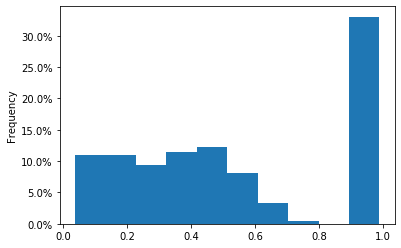

In [186]:
hate['offensive'].plot(kind='hist', weights=np.ones(len(hate)) / len(hate))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()